In [52]:
import numpy as np 
import os 
os.environ["KERAS_BACKEND"] = "jax"
import keras 
import pytest
from numpy import ndarray
import torch as th

In [53]:
class UpsamplingLayer(keras.layers.Layer):
    
    def __init__(self, channel_size: int, name=None):
        super().__init__(name=name)
        self.transposed_conv = keras.layers.Conv2DTranspose(channel_size, kernel_size=3, strides=(2,2), activation='relu', padding="same")
        self.concatenate_layer = keras.layers.Concatenate(axis=-1)
        self.convolution_layer = keras.layers.Conv2D(channel_size, kernel_size=(3, 3), activation="relu", padding="same")

    def call(self, x: ndarray, skip_tensor: ndarray) -> ndarray:
        x = self.transposed_conv(x)
        x = self.concatenate_layer([x, skip_tensor])
        x = self.convolution_layer(x)
        return x
     

In [54]:
class DownsamplingLayer(keras.layers.Layer):
    
    def __init__(self, channel_size: int, name=None):
        super().__init__(name=name)
        self.convoluation_layer = keras.Sequential(
            [
                keras.layers.Conv2D(channel_size, kernel_size=(3, 3), activation="relu", padding="same"),
                keras.layers.Conv2D(channel_size, kernel_size=(3, 3), activation="relu", padding="same"),
            ]
        )
        self.max_pooling_layer = keras.layers.MaxPooling2D(pool_size=(2, 2))

    def call(self, x):
        y = self.convoluation_layer(x)
        z = self.max_pooling_layer(y)
        return z, y

In [61]:
class UNET(keras.Model):
    def __init__(self):
        super().__init__()

        self.cl1 = DownsamplingLayer(16)
        self.cl2 = DownsamplingLayer(32)
        self.cl3 = DownsamplingLayer(64)
        self.cl4 = DownsamplingLayer(128)
        self.cl5 = DownsamplingLayer(256)

        self.inner_conv_block = keras.Sequential(
            [
                keras.layers.Conv2D(512, kernel_size=(1, 1), activation="relu"),
                keras.layers.Conv2D(512, kernel_size=(1, 1), activation="relu"),
            ]
        )

        self.ul1 = UpsamplingLayer(256)
        self.ul2 = UpsamplingLayer(128)
        self.ul3 = UpsamplingLayer(64)
        self.ul4 = UpsamplingLayer(32)
        self.ul5 = UpsamplingLayer(16)

        self.output_layer = keras.layers.Conv2D(6, kernel_size=(1, 1), activation="sigmoid")

    def call(self, x: ndarray) -> ndarray:

        x, y1 = self.cl1(x)
        x, y2 = self.cl2(x)
        x, y3 = self.cl3(x)
        x, y4 = self.cl4(x)
        x, y5 = self.cl5(x)

        x = self.inner_conv_block(x)

        x = self.ul1(x,y5)
        x = self.ul2(x,y4)
        x = self.ul3(x,y3)
        x = self.ul4(x,y2)
        x = self.ul5(x,y1)

        x = self.output_layer(x)

        return x

In [66]:
class STFTLayer(keras.layers.Layer):
    
    def __init__(self, sequence_length: int, sequence_stride: int, fft_length: int, name=None):
        super().__init__(name=name)
        self.sequence_length = sequence_length
        self.sequence_stride = sequence_stride
        self.fft_length = fft_length

    def call(self, x: ndarray) -> tuple[ndarray,tuple[ndarray,ndarray]]:

        # input shape: x.shape == (3,6000)
        # output shape: stft.shape == (6,182,32)

        stft = keras.ops.stft(
            x, self.sequence_length, self.sequence_stride, self.fft_length, window="hann", center=True
            ) 
        
        stft_normalized = 
        
        return stft_normalized, stft

In [144]:
import ipytest
ipytest.autoconfig()

def test_upsampling():
    layer = UpsamplingLayer(256)
    skip_tensor = np.zeros((1,16,16,256))
    current_input = np.zeros((1,8,8,512))

    assert layer(current_input, skip_tensor).shape == (1,16,16,256)

def test_downsampling_before_max_pooling():
    layer = DownsamplingLayer(16)
    current_input = np.zeros((1,256,256,6))
    after_max, before_max = layer(current_input)
    assert before_max.shape == (1,256,256,16)

def test_downsampling_after_max_pooling():
    layer = DownsamplingLayer(16)
    current_input = np.zeros((1,256,256,6))
    after_max, before_max = layer(current_input)
    assert after_max.shape == (1,128,128,16)

def test_UNET():
    input_shape = (1,128, 32,6)
    model = UNET()
    current_input = np.zeros(input_shape)
    output = model(current_input)
    assert output.shape == input_shape

def test_STFT():
    layer = STFTLayer(63,33,63)
    input = np.zeros((3,6000))
    output = layer(input)
    assert output[0][0].shape == (3,182, 32)
    

ipytest.run('-vv')

======================================= test session starts =======================================
platform win32 -- Python 3.12.3, pytest-8.3.3, pluggy-1.5.0 -- c:\Users\cleme\miniconda3\envs\dsl\python.exe
cachedir: .pytest_cache
rootdir: c:\Users\cleme\ETH\Master\DataLab\dsl-as24-challenge-3
plugins: anyio-4.2.0, typeguard-4.3.0
collecting ... collected 5 items

t_04cef47487e049db8e24cf50c9e5a823.py::test_upsampling PASSED                                [ 20%]
t_04cef47487e049db8e24cf50c9e5a823.py::test_downsampling_before_max_pooling PASSED           [ 40%]
t_04cef47487e049db8e24cf50c9e5a823.py::test_downsampling_after_max_pooling PASSED            [ 60%]
t_04cef47487e049db8e24cf50c9e5a823.py::test_UNET PASSED                                      [ 80%]
t_04cef47487e049db8e24cf50c9e5a823.py::test_STFT PASSED                                      [100%]

======================================== 5 passed in 1.09s ========================================


<ExitCode.OK: 0>

In [140]:
import matplotlib.pyplot as plt

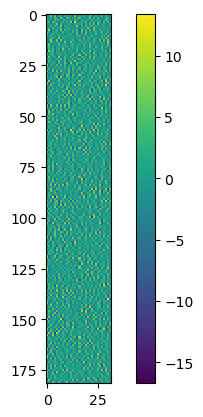

In [142]:
layer = STFTLayer(63,33,63)
input = np.random.normal(size=6000)
a = layer(input)
plt.imshow(a[0][0], cmap='viridis', interpolation='nearest')
plt.colorbar()


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
tensor = th.rand(6000)
th.stft(tensor, 511, return_complex=False).shape

torch.Size([256, 48, 2])

In [57]:
model = MarsQNetwork()
model.summary()

Model: "mars_q_network_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ stft_layer_30 (STFTLayer)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ unet_2 (UNET)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ istft_layer_2 (ISTFTLayer)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)